# Timeseries classification from scratch

**Author:** [hfawaz](https://github.com/hfawaz/)<br>
**Date created:** 2020/07/21<br>
**Last modified:** 2021/07/16<br>
**Description:** Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archive.

## Introduction

This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

## Setup

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

2023-07-19 03:44:58.913966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 03:44:59.028018: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).


```
$PATH/FordA$ tree -s
[       4096]  .
├── [    7364408]  FordA_TEST.tsv
└── [   20094049]  FordA_TRAIN.tsv
```



### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

print(f'Train data: x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'Test data: x_test {x_test.shape}, {y_test.shape}')

Train data: x_train: (3601, 500), y_train: (3601,)
Test data: x_test (1320, 500), (1320,)


## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

idx: 1700
    class -1 with c_x_train.shape (1846, 500)
    class 1 with c_x_train.shape (1755, 500)


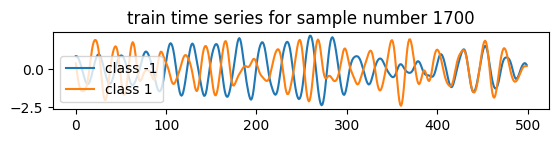

idx: 1701
    class -1 with c_x_train.shape (1846, 500)
    class 1 with c_x_train.shape (1755, 500)


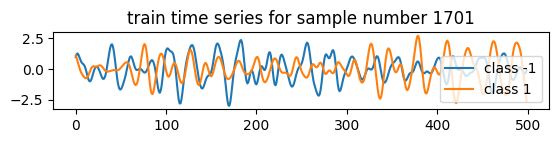

idx: 1702
    class -1 with c_x_train.shape (1846, 500)
    class 1 with c_x_train.shape (1755, 500)


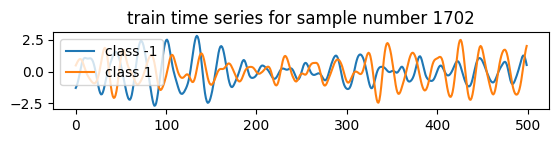

idx: 1703
    class -1 with c_x_train.shape (1846, 500)
    class 1 with c_x_train.shape (1755, 500)


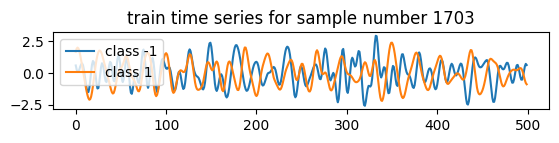

idx: 1704
    class -1 with c_x_train.shape (1846, 500)
    class 1 with c_x_train.shape (1755, 500)


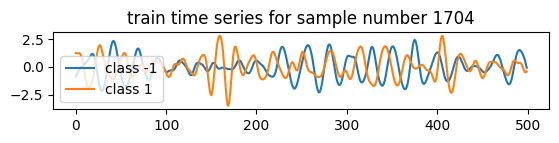

In [3]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))


start_sample_numbers=1700
end_interval=5

for idx in range(start_sample_numbers,start_sample_numbers+end_interval):
    print(f'idx: {idx}')    
    plt.figure().set_figheight(1)
    for c in classes:
        c_x_train = x_train[y_train == c]
        print(f'    class {c} with c_x_train.shape {c_x_train.shape}')
        plt.plot(c_x_train[idx], label="class " + str(c))


    plt.legend(loc="best")
    plt.title(f'train time series for sample number {idx}')
    plt.show()
    plt.close()

## Standardize the data

Our timeseries are already in a single length (500). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [4]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


print(f'x_train.shape: {x_train.shape}, x_test.shape {x_test.shape}')

x_train.shape: (3601, 500, 1), x_test.shape (1320, 500, 1)


Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [5]:
num_classes = len(np.unique(y_train))
print(f'y_train.shape: {y_train.shape}')
print(f'num_classes: {num_classes}')

y_train.shape: (3601,)
num_classes: 2


Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [6]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [7]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

input_shape: (500, 1)
input_layer: KerasTensor(type_spec=TensorSpec(shape=(None, 500, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


2023-07-19 03:45:03.122380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:45:03.154078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:45:03.154308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:45:03.156248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other 

output_layer: KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


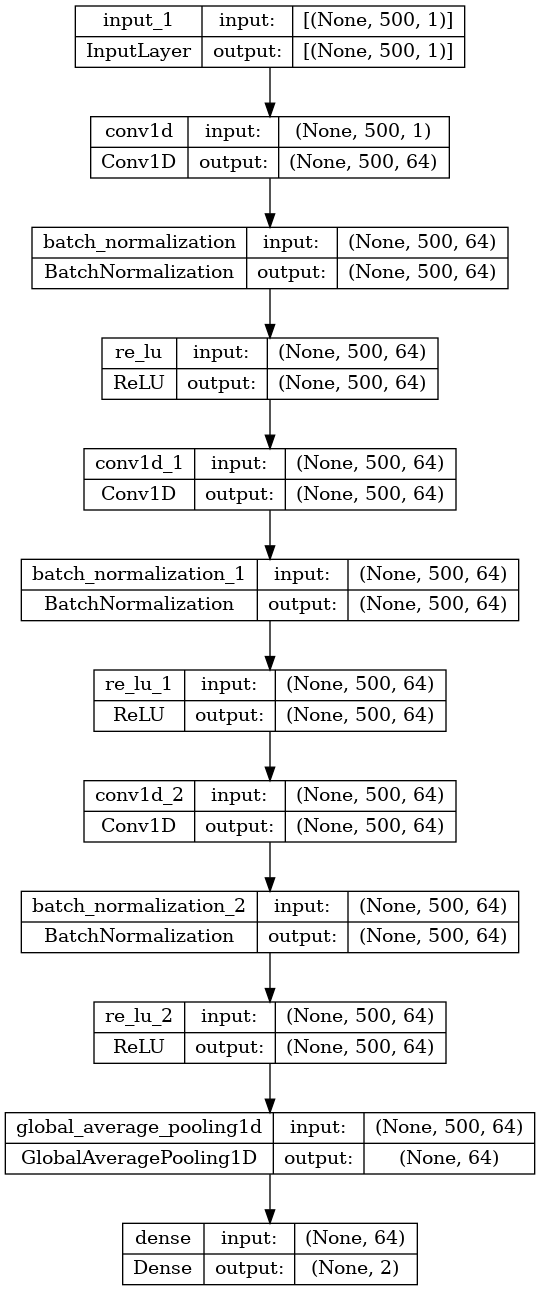

In [8]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    print(f'input_layer: {input_layer}')

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)
    print(f'output_layer: {output_layer}')

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

input_shape=x_train.shape[1:]
print(f'input_shape: {input_shape}')
model = make_model(input_shape=input_shape)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [18]:
# epochs = 2
# epochs = 10
# epochs = 50
epochs = 100
# epochs = 300
# epochs = 500

# batch_size = 16
# batch_size = 32
batch_size = 64

callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    #keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

# Model training APIs (methods for compile, fit, evaluate)
# https://keras.io/api/models/model_training_apis/

Epoch 1/100
45/45 [==============================] - 3s 19ms/step - loss: 0.2539 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.2546 - val_sparse_categorical_accuracy: 0.8821 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 1s 14ms/step - loss: 0.2450 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.3096 - val_sparse_categorical_accuracy: 0.8530 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 1s 15ms/step - loss: 0.2422 - sparse_categorical_accuracy: 0.9042 - val_loss: 0.2694 - val_sparse_categorical_accuracy: 0.8724 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - 1s 15ms/step - loss: 0.2425 - sparse_categorical_accuracy: 0.9045 - val_loss: 0.2318 - val_sparse_categorical_accuracy: 0.9140 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - 1s 15ms/step - loss: 0.2300 - sparse_categorical_accuracy: 0.9087 - val_loss: 0.2321 - val_sparse_categorical_accuracy: 0.8960 - lr: 0.0010
Epoch 6/100
45/45 [================

45/45 [==============================] - 1s 16ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.0954 - val_sparse_categorical_accuracy: 0.9723 - lr: 5.0000e-04
Epoch 86/100
45/45 [==============================] - 1s 19ms/step - loss: 0.0844 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.0936 - val_sparse_categorical_accuracy: 0.9639 - lr: 5.0000e-04
Epoch 87/100
45/45 [==============================] - 1s 15ms/step - loss: 0.0854 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.0853 - val_sparse_categorical_accuracy: 0.9709 - lr: 5.0000e-04
Epoch 88/100
45/45 [==============================] - 1s 14ms/step - loss: 0.0777 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.0904 - val_sparse_categorical_accuracy: 0.9667 - lr: 5.0000e-04
Epoch 89/100
45/45 [==============================] - 1s 15ms/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.1016 - val_sparse_categorical_accuracy: 0.9667 - lr: 5.0000e-04
Epoch 90/100
45/45 [===

## Evaluate model on test data

In [19]:
model = keras.models.load_model("best_model.h5")
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 0s 5ms/step - loss: 0.0984 - sparse_categorical_accuracy: 0.9667
Test accuracy 0.9666666388511658
Test loss 0.09842848032712936


## Plot the model's training and validation loss

history.params: {'verbose': 1, 'epochs': 100, 'steps': 45}
history.history.keys(): dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


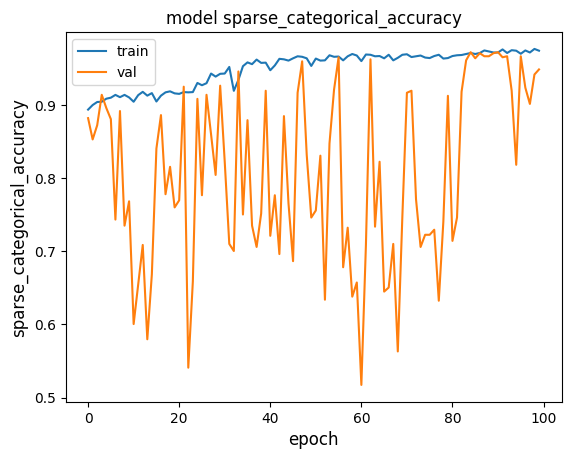

In [20]:
metric = "sparse_categorical_accuracy"

print(f'history.params: {history.params}' )
print(f'history.history.keys(): {history.history.keys()}')

plt.figure()

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.plot(history.history['lr'])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.